# E-commerce A/B test 

The notebook provides an analysis of a e-commerce website A/B test results. <br>
The workflow was learned from the Data Analyst Nano Degree course on Udacity.

## Table of contents
1. Set objectives [link](#objective)
2. Clean data [link](#clean)
3. Analyze the results [link](#analyze)

In [21]:
# Load packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
%matplotlib inline

<span id="objective"></span>

## 1. Set objectives
Discussion on objective and methodology will be followed by a quick data exploration.

### Load and explore data 

In [2]:
## Load dataset

df = pd.read_csv('./ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# Explore data structure

print('Total data records:', df.shape[0])
print('Unique groups in test:', df['group'].unique())
print('Unique pages to test:', df['landing_page'].unique())
print('Unique values for converision:', df['converted'].unique())

Total data records: 294478
Unique groups in test: ['control' 'treatment']
Unique pages to test: ['old_page' 'new_page']
Unique values for converision: [0 1]


In [4]:
# Size of the dataset by each group

df.groupby('group').size()

group
control      147202
treatment    147276
dtype: int64

In [33]:
# Period of the study

print('The study ranges between: {} and {}'.format(pd.to_datetime(df['timestamp']).min().date(), 
                                                   pd.to_datetime(df['timestamp']).max().date()))

The study ranges between: 2017-01-02 and 2017-01-24


#### Quick findings

- The data were gathered to analyze the effectiveness of a e-commerce website design change. 
- Assumption: the participants are randomly divided into the two test groups: control and treatment. Then, control group is provided with old page whereas treatment group is provided with new page. 
- Each group has similar data size.
- The period of this study is between 2017-01-02 and 2017-01-24 (about 3 weeks). 

### Objective

The objective is to evaluate if there is a noticeable difference in conversion rate between two test groups. Each group should be provided with different page: old or new page. 

Hypotheses are given as following:

- $H_{0}: C_{new} - C_{old} <= 0$
- $H_{1}: C_{new} - C_{old} > 0$

C stands for conversion rate.

If the null hypothesis $H_{0}$ can be rejected in favor of $H_{1}$, a new page will be considered for deployment. Before the actual deployment, pratical assessments on costs, time, other constraints.


### Methodology

Firstly, data cleaning will be performed to handle missing, duplicated or incorrect data records. <br>
Statistical methods will then be applied to test if the new page is more effective in conversion than the old page. 

Three approaches will be taken:
1. Simulation
2. Z-test (using scipy function)
3. Regression 


---
<span id="clean"></span>

## 2. Clean dataset
- validate data records
- handle missing and duplicated values

### Validate data records
Each group must be associated clearly with one of the two test pages:
- control: old page
- treatment: new page

Let's inspect if there are inconsistant data records.

In [38]:
# Filter inconsistent records (control - new page)

df.query('group == "control" & landing_page == "new_page"')

,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
490,808613,2017-01-10 21:44:01.292755,control,new_page,0
846,637639,2017-01-11 23:09:52.682329,control,new_page,1
850,793580,2017-01-08 03:25:33.723712,control,new_page,1
...,...,...,...,...,...
293894,741581,2017-01-09 20:49:03.391764,control,new_page,0
293996,942612,2017-01-08 13:52:28.182648,control,new_page,0
294200,928506,2017-01-13 21:32:10.491309,control,new_page,0
294253,886135,2017-01-06 12:49:20.509403,control,new_page,0


In [40]:
# Filter inconsistent records (treatment - old page)

df.query('group == "treatment" & landing_page == "old_page"')

,user_id,timestamp,group,landing_page,converted
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0
685,666385,2017-01-23 08:11:54.823806,treatment,old_page,0
713,748761,2017-01-10 15:47:44.445196,treatment,old_page,0
...,...,...,...,...,...
293773,688144,2017-01-16 20:34:50.450528,treatment,old_page,1
293817,876037,2017-01-17 16:15:08.957152,treatment,old_page,1
293917,738357,2017-01-05 15:37:55.729133,treatment,old_page,0
294014,813406,2017-01-09 06:25:33.223301,treatment,old_page,0


In [70]:
df[df.duplicated(subset='user_id', keep=False)].sort_values(by='user_id')

,user_id,timestamp,group,landing_page,converted
230259,630052,2017-01-17 01:16:05.208766,treatment,new_page,0
213114,630052,2017-01-07 12:25:54.089486,treatment,old_page,1
22513,630126,2017-01-14 13:35:54.778695,treatment,old_page,0
251762,630126,2017-01-19 17:16:00.280440,treatment,new_page,0
183371,630137,2017-01-20 02:08:49.893878,control,old_page,0
...,...,...,...,...,...
142354,945703,2017-01-08 19:40:51.169351,control,new_page,0
186960,945797,2017-01-13 17:23:21.750962,control,old_page,0
40370,945797,2017-01-11 03:04:49.433736,control,new_page,1
165143,945971,2017-01-16 10:09:18.383183,control,old_page,0


There are limited information on how these incorrect data have been generated. This issue comes from the duplicated assignments, for example, the same user is assigned with both old and new page and it is completely incorrect.

In the real work setting, this issue must be clarified bewteen departments. However, for this project, these inconsistent records will be dropped (acconts for 1.3% of total records, calculated as (1928+1965) / 294478).

In [3]:
# Save mismatched records in a dataframe

mismatch1 = df.query('group == "control" & landing_page == "new_page"')
mismatch2 = df.query('group == "treatment" & landing_page == "old_page"')
mismatched_records = mismatch1.append(mismatch2)

In [4]:
# Drop the records and check 

df_clean = df.drop(index=mismatched_records.index)
assert df_clean.query('group == "control" & landing_page == "new_page"').shape[0] == 0, 'ERROR: some records in control still have new page assigned.'
assert df_clean.query('group == "treatment" & landing_page == "old_page"').shape[0] == 0, 'ERROR: some records in treatment still have old page assigned.'

### Inspect null and duplicated values

In [7]:
# Find duplicated values across different columns

df_clean.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

No missing records across columns.

In [8]:
# Find duplicated data records by user_id

df_clean.duplicated(subset='user_id').sum()

1

In [9]:
df_clean[df_clean.duplicated(subset='user_id', keep=False)].sort_values(by='user_id')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


The earlier cleaning for mismatched records removed most of the duplicated entries.  As the two duplicated records deliver the same information under the same user, drop one of them.

In [5]:
# Drop the duplicated records

df_clean.drop_duplicates(subset='user_id', keep='first', inplace=True)
assert df_clean.duplicated(subset='user_id').sum() == 0, 'ERROR: Duplicated records still exist.'

---
<span id="analyze"></span>
    
## 3. Analyze the results

### Method 1. Simulation

In [12]:
df_clean

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [6]:
# Divide up control and treatment group

df_control = df_clean.query('group == "control" and landing_page == "old_page"')
df_treatment = df_clean.query('group == "treatment" and landing_page == "new_page"')

# Compute the grup size
n_control = df_control.shape[0]
n_treatment = df_treatment.shape[0]
print('Control group size:', n_control)
print('Treatment group size:', n_treatment)

Control group size: 145274
Treatment group size: 145310


In [7]:
# Calculate conversion rate (cr)

cr_control = df_control['converted'].mean()
cr_treatment = df_treatment['converted'].mean()
print('Conversion rate - control: {:.2f}%'.format(cr_control * 100))
print('Conversion rate - treatment: {:.2f}%'.format(cr_treatment * 100))

Conversion rate - control: 12.04%
Conversion rate - treatment: 11.88%


The actual conversion rate is higher for the control group with the old page. Considering the extra resources to launch a new page (i.e. time, costs, etc.), it is not a good idea to invest into the new page which is expected to produce lower conversion rate.

Now, let's simulate the results under the null hypothesis to validate statistical significance of this result. 
The null assumes the difference between control and treatment is zero. 

In [8]:
# Run simulation under the null hypothesis

cr_diff_null = []

n_sim = 10000
cr_null = df_clean['converted'].mean()

for i in tqdm(range(n_sim)):
    sim_conv_control = np.random.binomial(1, cr_null, n_control)
    sim_conv_treatment = np.random.binomial(1, cr_null, n_treatment)
    
    cr_diff = sim_conv_treatment.mean() - sim_conv_control.mean()
    cr_diff_null.append(cr_diff)
    

100%|██████████| 10000/10000 [00:37<00:00, 268.99it/s]


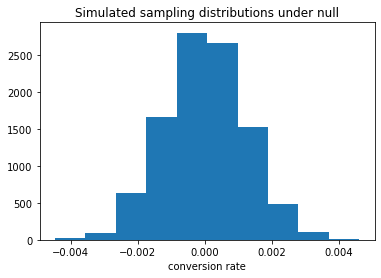

In [9]:
plt.hist(cr_diff_null)
plt.title('Simulated sampling distributions under null')
plt.xlabel('conversion rate')
plt.show()

The samples are normally distributed - Z score will be calculated for the actual conversion rate difference. P-value will tell the probability of observing the statistics given that the null hypothesis is true.

In [10]:
# Calculate the actual difference in conversion rate

cr_diff_actual = cr_treatment - cr_control
cr_diff_actual

-0.0015782389853555567

In [12]:
# Calculate p-value (one-sided)

(cr_diff_actual < cr_diff_null).mean()

0.9009

The c p_value (**0.9009**) is extremely higher than the alpha rate 0.05 (a Type I error), indicating it fails to reject the the null hypothesis ( $H_{0}: C_{new}-C_{old}<=0$). Therefore, the new page is not effective than the old page in terms of conversion rate.

### Method 2 : Z-test
Using statsmodels API

    import statsmodels.api as sm
    from scipy.stats import norm

In [14]:
conv_control = df_control['converted'].sum()
conv_treatment = df_treatment['converted'].sum()
n_control = df_control.shape[0]
n_treatment = df_treatment.shape[0]

In [20]:
z_score, p_val = sm.stats.proportions_ztest(count=[conv_control, conv_treatment], 
                                            nobs=[n_control, n_treatment], 
                                            alternative='smaller') # In the two sample test, 
                                            # smaller means that the alternative hypothesis is ``p1 < p2`
print('Z score:', z_score)
print('P value:', p_val)

Z score: 1.3109241984234394
P value: 0.9050583127590245


In [ ]:
# This time,
# use z-score to make a decision

crit_val = norm.ppf(1-0.05)
print('Critical value:' crit_val)

Critical value: 1.6448536269514722


The computed z-score for the two sample test is 1.31, which is less than the critical value of 1.64 (alpha=0.05, one-sided), meaning it fails to reject the null. In more intutive description, the conversion on the new page is no better than that on the old page - the same result as the previous case using simulation.

### Method 3. Regression
Using statsmodels API

    import statsmodels.formula.api as smf
    

In [22]:
df_clean.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


In [32]:
# Map groups into numeric value

df_clean['group_num'] = df_clean['group'].map({'control':0, 'treatment':1})
df_clean.head(3)

,user_id,timestamp,group,landing_page,converted,group_num
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1


In [34]:
# Fit logistic regression model

model = smf.logit(formula='converted~group_num', data=df_clean).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 13 Feb 2022   Pseudo R-squ.:               8.077e-06
Time:                        11:24:18   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
group_num     -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

The resulted p-value (0.190) is far greater than the alpha rate of 0.05. Therefore, the effect between old and new page into conversion rate is not statistically significant.